In [ ]:
!pip install transformers torch datasets
!pip install pandas spacy tensorflow imbalanced-learn
!python -m spacy download en_core_web_sm

In [ ]:
# Import required libraries
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone Material/Hyperparameter Tuned/Datasets/spelling_correct_with_removeNumber - spelling_correct_with_removeNumber.csv')
df

,sentence,labels
0,in going to go,0
1,in going to say goodby to the drugstore,0
2,i think that this is the way it should be done...,0
3,in going to join you,0
4,its illegal,0
...,...,...
25565,i saw that there are people like musfakur him ...,0
25566,papa she is trying to avoid responsibility here,0
25567,said needs the bangladesh team,0
25568,you keep going we ll take your shot,0


In [ ]:
!pip install transformers==4.33.2 # Install a compatible version of the transformers library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.33.2 which is incompatible.


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['sentence'], df['labels'], test_size=0.2, random_state=42)

In [ ]:
# Load the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Convert test_texts and train_texts to lists of strings and handle potential issues
train_texts = train_texts.astype(str).fillna('').tolist()  # Convert to strings, replace NaN with empty strings, and then to list
test_texts = test_texts.astype(str).fillna('').tolist()  # Convert to strings, replace NaN with empty strings, and then to list

model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base")

# Tokenize the training and testing data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#class HateSpeechDataset(torch.utils.data.Dataset):
import torch
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        #item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        #item['labels'] = torch.tensor(self.labels[idx])
        #return item
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

    def to_tf_dataset(self):
        # Convert the dictionary of encodings to a list of tensors
        dataset = tf.data.Dataset.from_tensor_slices((dict(self.encodings), self.labels))

        # Map the labels to be in a format that TensorFlow can use directly
        dataset = dataset.map(lambda x, y: ({key: tf.convert_to_tensor(val) for key, val in x.items()}, tf.convert_to_tensor(y)))

# Create the datasets
train_dataset = HateSpeechDataset(train_encodings, list(train_labels))
test_dataset = HateSpeechDataset(test_encodings, list(test_labels))

In [ ]:
# Install necessary libraries
!pip install transformers -qq
!pip install torch -qq
!pip install matplotlib -qq

# Import necessary libraries
import os
import matplotlib.pyplot as plt
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer, Trainer, TrainingArguments, TrainerCallback
#from datasets import load_dataset  # This is optional, use if you want to load data using Hugging Face Datasets library

# Deactivate wandb logging
os.environ["WANDB_DISABLED"] = "true"

# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

# Define your training and validation datasets (e.g., Hugging Face Datasets library can be used to load them)
# Example (replace this with loading your own data if needed):
# dataset = load_dataset('your_dataset_here')
# train_dataset = dataset['train']
# test_dataset = dataset['test']

# Custom callback to log training and validation losses
class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs:
            self.train_losses.append(logs['loss'])

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])

# Initialize the callback
loss_callback = LossHistoryCallback()

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # Use a smaller epoch count for faster testing
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"  # Runs evaluation at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[loss_callback]
)

# Train the model
trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-15-6513942ab20b>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.425900,0.388798
2,0.386800,0.379140
3,0.326900,0.477047
4,0.664000,0.682470


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 52096 vs 51988

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Initialize the model
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
new_var = trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  raise ValueError("`--sharded_ddp simple` is not compatible with any other option.")
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.610900,0.539865
2,0.639000,0.608435
3,0.590500,0.636917
4,0.617600,0.610582
5,0.515000,0.550718


In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)  # Get raw predictions and labels
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
accuracy = accuracy_score(labels, predicted_labels)

# Print the accuracy
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7344


# **Confusion Matrix**
Source: https://youtu.be/8gLewErTU24?si=IYIN6qnx0ylYFSok

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(test_labels, predicted_labels)

array([[1943,  190],
       [ 930, 1154]])

In [ ]:
#Getting dataframe labels

from sklearn.utils.multiclass import unique_labels
unique_labels(test_labels)

array([0, 1])

In [ ]:
#Combining these labels with the confusion matrix

def plot(y_true, y_pred):
  labels = unique_labels(test_labels)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)

  return table

In [ ]:
plot(test_labels, predicted_labels)

,Predicted 0,Predicted 1
Actual 0,1943,190
Actual 1,930,1154


In [ ]:
import seaborn as sns

In [ ]:
def plot2(y_true, y_pred):
  labels = unique_labels(test_labels)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)

  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

<Axes: >

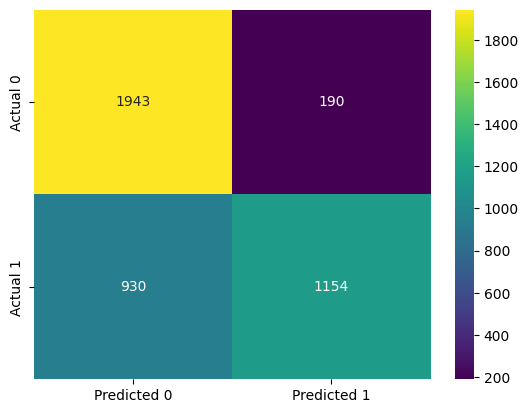

In [ ]:
plot2(test_labels, predicted_labels)

# Confusion Matrix Explanation
Source: https://youtu.be/9w4HJ0VUy2g?si=kztEAMH8xBtYNRfw


In [ ]:
True_positive = 1282
True_negetive = 622
False_positive = 155
False_negetive = 143

In [ ]:
recall = True_positive/(True_positive + False_negetive)
recall

0.8996491228070176

In [ ]:
precision = True_positive/(True_positive + False_positive)
precision

0.8921363952679193

In [ ]:
f1_score = (precision * recall / (precision + recall)) * 2
f1_score

0.8958770090845564

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       777
           1       0.89      0.90      0.90      1425

    accuracy                           0.86      2202
   macro avg       0.85      0.85      0.85      2202
weighted avg       0.86      0.86      0.86      2202



In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80      3249
           1       0.80      0.75      0.78      3122

    accuracy                           0.79      6371
   macro avg       0.79      0.79      0.79      6371
weighted avg       0.79      0.79      0.79      6371



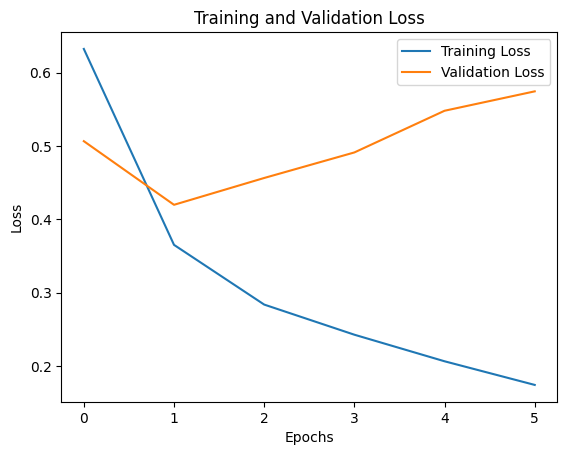

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss values
train_loss = history.history['loss']        # Training loss
val_loss = history.history['val_loss']      # Validation loss

# Plot both losses
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Get predictions on the test set
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = y_pred_prob.argmax(axis=1)  # Since you're using softmax, we take the argmax to get class labels

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
from sklearn.preprocessing import label_binarize

# One-hot encode the true labels
y_test_onehot = label_binarize(y_test, classes=[0, 1, 2])  # Adjust based on your number of classes


In [ ]:
# Get predicted probabilities for the test set
y_pred_prob = model.predict(X_test)  # This returns the softmax probabilities for each class


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


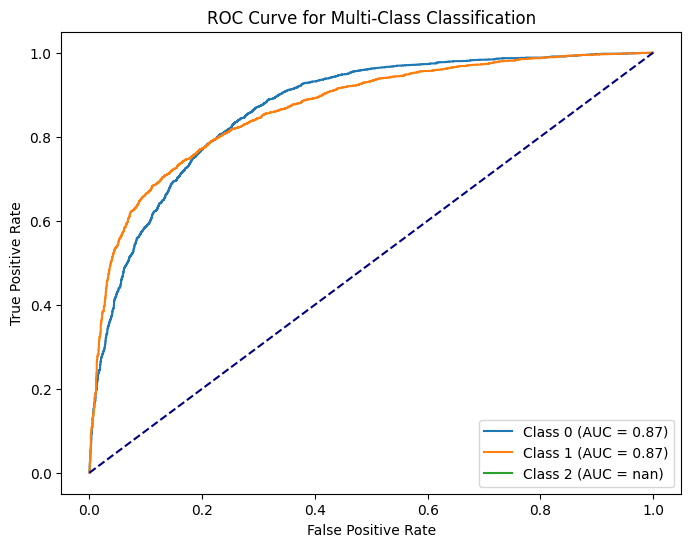

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Dictionary to hold the ROC metrics for each class
fpr = {}
tpr = {}
roc_auc = {}

# Compute the ROC curve for each class
for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.33.2 which is incompatible.


In [ ]:
# Step 1: Install Required Libraries (if not already installed)
!pip install transformers torch scikit-learn

# Step 2: Import Libraries
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 3: Load Model and Tokenizer
model_name = "xlm-roberta-base"  # Replace with your fine-tuned model name if needed
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

# Step 4: Prepare Your Dataset
# Assuming your dataset is a list of texts and corresponding labels
# Example:
# texts = ["Example sentence 1", "Example sentence 2", "Example sentence 3"]
# labels = [0, 1, 1]  # Replace with your actual dataset
texts = [YOUR_TEXTS_LIST]  # Replace with your test texts list
labels = [YOUR_LABELS_LIST]  # Replace with your true labels list

# Tokenize the text inputs
encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Step 5: Get Model Predictions
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities

# Step 6: Get Probability for Positive Class (class 1)
positive_probs = probabilities[:, 1].cpu().numpy()  # Probabilities for the positive class
true_labels = torch.tensor(labels).cpu().numpy()

# Step 7: Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, positive_probs)
roc_auc = auc(fpr, tpr)

# Step 8: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XLM-RoBERTa Binary Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Map:   0%|          | 0/4217 [00:00<?, ? examples/s]

OSError: your_checkpoint_name is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
# Install necessary packages
!pip install transformers datasets optuna

# Import necessary libraries
import optuna
import torch
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaTokenizer
from datasets import load_metric

# Load your dataset
# Replace this part with code to load your own dataset
# Example: If your dataset is a Pandas DataFrame, you could use `Dataset.from_pandas()`
# Make sure your dataset is in the Hugging Face Dataset format
from datasets import Dataset
# Replace `data` with your DataFrame or dataset path
# dataset = Dataset.from_pandas(data)

# Example splitting (modify as needed)
train_dataset = dataset["train"]  # Replace with your train dataset
test_dataset = dataset["test"]    # Replace with your test dataset

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Preprocess data
def preprocess_data(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

# Tokenize the dataset
train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Define compute metrics function for evaluation
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(logits, dim=-1)
    return metric.compute(predictions=predictions, references=labels)

# Objective function for hyperparameter optimization
def objective(trial):
    # Define the model
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

    # Define training arguments with hyperparameters to be tuned
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=trial.suggest_loguniform("learning_rate", 1e-5, 5e-5),
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        num_train_epochs=trial.suggest_int("num_train_epochs", 2, 5),
        weight_decay=trial.suggest_loguniform("weight_decay", 1e-4, 0.1),
        logging_dir='./logs',
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Return the accuracy as the objective to maximize
    return eval_result["eval_accuracy"]

# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Display the best hyperparameters
print("Best hyperparameters found: ", study.best_params)


In [ ]:
# Install necessary packages
!pip install transformers sklearn

# Import necessary libraries
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import ParameterGrid
import torch
from datasets import load_metric

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Preprocess data (assuming `train_dataset` and `test_dataset` are already loaded)
def preprocess_data(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

# Tokenize datasets
train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Define compute metrics function for evaluation
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(logits, dim=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define the parameter grid
param_grid = {
    "learning_rate": [1e-5, 3e-5, 5e-5],
    "per_device_train_batch_size": [8, 16, 32],
    "num_train_epochs": [2, 3, 4],
    "weight_decay": [0.0, 0.01, 0.1],
}

best_accuracy = 0
best_params = {}

# Hyperparameter tuning with grid search
for params in ParameterGrid(param_grid):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=params["learning_rate"],
        per_device_train_batch_size=params["per_device_train_batch_size"],
        num_train_epochs=params["num_train_epochs"],
        weight_decay=params["weight_decay"],
        logging_dir='./logs',
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate the model
    trainer.train()
    eval_result = trainer.evaluate()

    # Update best parameters if a higher accuracy is found
    if eval_result["eval_accuracy"] > best_accuracy:
        best_accuracy = eval_result["eval_accuracy"]
        best_params = params

# Display the best hyperparameters
print("Best hyperparameters found: ", best_params)


In [ ]:
import random
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
import torch
from datasets import load_metric

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Preprocess data (assuming `train_dataset` and `test_dataset` are already loaded)
def preprocess_data(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

# Tokenize datasets
train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Define compute metrics function for evaluation
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(logits, dim=-1)
    return metric.compute(predictions=predictions, references=labels)

# Random search for hyperparameter tuning
def random_search(num_trials=10):
    best_accuracy = 0
    best_params = {}

    for _ in range(num_trials):
        params = {
            "learning_rate": random.uniform(1e-5, 5e-5),
            "per_device_train_batch_size": random.choice([8, 16, 32]),
            "num_train_epochs": random.choice([2, 3, 4]),
            "weight_decay": random.uniform(1e-4, 0.1),
        }

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=params["learning_rate"],
            per_device_train_batch_size=params["per_device_train_batch_size"],
            num_train_epochs=params["num_train_epochs"],
            weight_decay=params["weight_decay"],
            logging_dir='./logs',
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        eval_result = trainer.evaluate()

        # Update best parameters if a higher accuracy is found
        if eval_result["eval_accuracy"] > best_accuracy:
            best_accuracy = eval_result["eval_accuracy"]
            best_params = params

    print("Best hyperparameters found: ", best_params)

# Run the random search
random_search(num_trials=10)

In [ ]:
!pip install scikit-optimize

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import load_metric

# Load RoBERTa tokenizer and model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Define the hyperparameter space
space = [
    Real(1e-5, 5e-5, name="learning_rate"),
    Integer(8, 32, name="batch_size"),
    Integer(2, 5, name="num_train_epochs"),
    Real(1e-4, 0.1, name="weight_decay"),
]

# Load metric for evaluation
metric = load_metric("accuracy")

@use_named_args(space)
def objective(params):
    learning_rate, batch_size, num_train_epochs, weight_decay = params

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        logging_dir='./logs',
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_result = trainer.evaluate()

    # Minimize negative accuracy
    return -eval_result["eval_accuracy"]

# Run Bayesian Optimization
result = gp_minimize(objective, space, n_calls=10, random_state=0)

print("Best hyperparameters found: ", result.x)


In [ ]:
!pip install keras-tuner

import keras_tuner as kt
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import torch

def build_model(hp):
    # Define hyperparameters
    learning_rate = hp.Float("learning_rate", 1e-5, 5e-5, sampling="log")
    batch_size = hp.Choice("batch_size", [8, 16, 32])
    num_train_epochs = hp.Int("num_train_epochs", 2, 5)
    weight_decay = hp.Float("weight_decay", 1e-4, 0.1, sampling="log")

    # Load RoBERTa model
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        logging_dir='./logs',
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Return accuracy for optimization
    return eval_result["eval_accuracy"]

# Define tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=5,
    factor=3,
    directory="hyperband",
    project_name="roberta_tuning"
)

# Run the tuner
tuner.search()
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found: ", best_hps)